#### python import

In [1]:
import os
import pandas as pd
import numpy as np
import lmfit
import glob
import platform
import json
from skimage.filters import median
from skimage.morphology import disk

from ipywidgets import interactive
from IPython.core.display import HTML
from IPython.display import display

import ipywidgets as widgets

import pprint

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib notebook

## Images size 

In [2]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")
print(f"number of pixels: {image_width * image_height:_}")
print(f"original image is 122MB")

image_height/2 =3194.0
number of pixels: 61_171_488
original image is 122MB


### theoretical center position 

In [3]:
perfect_center_x_px = 4869
perfect_center_y_px = 3216

### Pixel size 

this has been calculated by the notebook [calculation of pixel size](calculation_of_pixel_size.ipynb)

In [4]:
pixel_size = 51.010e-3  # mm   

### beam size 

In [5]:
beam_diameter_mm = 22.2157e1 # mm
beam_diameter_px = np.round(beam_diameter_mm / pixel_size)
print(f"{beam_diameter_px = }")
beam_radius_px = beam_diameter_px / 2
beam_radius_mm = beam_diameter_mm / 2

beam_diameter_px = 4355.0


# User input 

Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*top_folder* = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis/"


In [6]:
if platform.node() == "mac113775":
    top_folder = "/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis/"
elif platform.system() == "Linux":
    top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis"    
else:
    top_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever"

### set up base folder 

In [7]:
base_folder = top_folder + "/profiles/beam_center_for_all_apertures"
assert os.path.exists(base_folder)  # making sure the base folder exists

# Loading the data

In [8]:
base_folder = top_folder + "/median_data/"
list_images_to_load = glob.glob(os.path.join(base_folder, "*.tif*"))
list_images_to_load.sort()
assert len(list_images_to_load)>0

In [9]:
progress_bar = widgets.IntProgress()
progress_bar.max = len(list_images_to_load)
display(progress_bar)

images = {}
for _image_filename in list_images_to_load:
    _key = os.path.basename(_image_filename)
    image = np.asarray(Image.open(_image_filename))
    images[_key] = image
    progress_bar.value += 1
    
progress_bar.close()
print("All images have been loaded!")

IntProgress(value=0, max=21)

All images have been loaded!


# display the data 

<IPython.core.display.Javascript object>


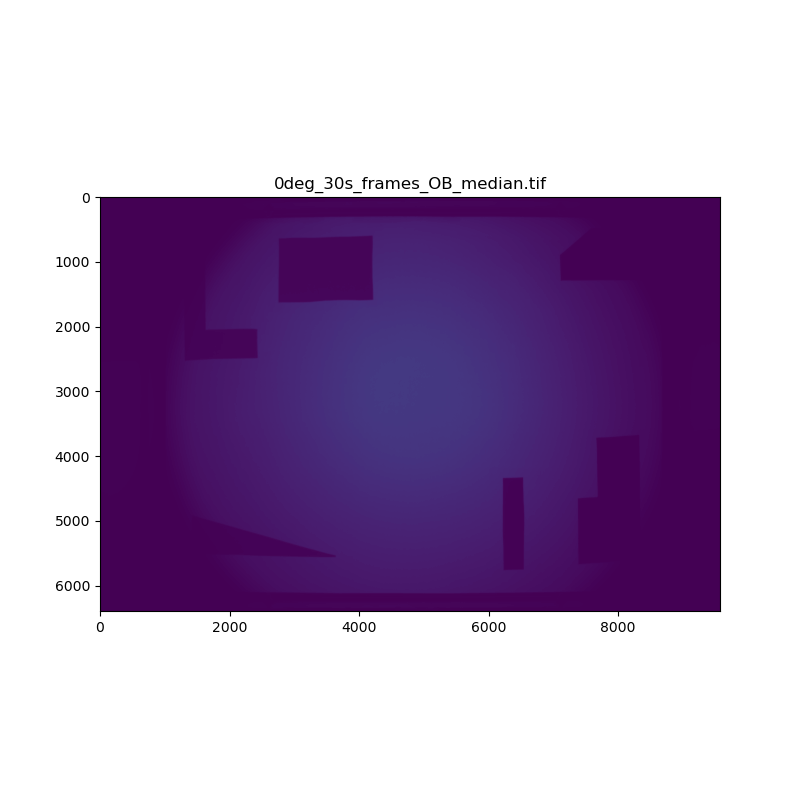

interactive(children=(Dropdown(description='file_name', layout=Layout(width='500px'), options=('0deg_30s_frame…

In [10]:
fig, axis = plt.subplots(num="Images", figsize=(8, 8), nrows=1, ncols=1)

vmin_value = 0
vmax_value = 65500

def plot(file_name, vmin, vmax):

    data = images[file_name]
    axis.imshow(data, vmin=vmin, vmax=vmax)
    axis.set_title(file_name)
    
    return file_name, vmin, vmax
    
display_images = interactive(plot,
                            file_name = widgets.Dropdown(options=images.keys(),
                                                        layout=widgets.Layout(width="500px")),
                            vmin = widgets.FloatSlider(min=vmin_value,
                                          max=vmax_value,
                                          value=vmin_value,
                                          continuous_update=False),
                            vmax = widgets.FloatSlider(min=vmin_value,
                                                       max=vmax_value,
                                                       value=vmax_value,
                                                       continuous_update=False),
                           )
display(display_images)

# Load center position of each aperture 

those data have been produced in the notebook **beam_shape_display_around_beam_center_and_over_image**

In [14]:
with open(os.path.join(top_folder, "all_apertures_beam_center.json"), 'r') as infile:
    mean_centers = json.load(infile)

In [15]:
mean_centers

{'0deg': {'x': 4780.0, 'y': 2955.0},
 '120deg': {'x': 4656.0, 'y': 2682.0},
 '180deg': {'x': 4612.0, 'y': 2654.0},
 '240deg': {'x': 4552.0, 'y': 2639.0},
 '300deg': {'x': 4593.0, 'y': 2726.0},
 '60deg': {'x': 4705.0, 'y': 2808.0}}

### calculate the intensity value at those points using a median region

In [16]:
def filename_starts_with(filename):
    split_filename = filename.split("_")
    return split_filename[0]

In [18]:
list_json_keys = mean_centers.keys()

for file in images.keys():
    
    key = filename_starts_with(file) 
    if key in list_json_keys:
        
        x = int(mean_centers[key]['x'])
        y = int(mean_centers[key]['y'])
        
        median_pixel_value = np.median([images[file][y, x],
                                        images[file][y-1,x-1],
                                        images[file][y-1,x],
                                        images[file][y-1,x+1],
                                        images[file][y,x+1],
                                        images[file][y+1,x+1],
                                        images[file][y+1,x],
                                        images[file][y+1,x-1],
                                        images[file][y,x-1]])
        
        if mean_centers[key].get('intensity', None):
            mean_centers[key]['intensity'].append(median_pixel_value)
        else:
            mean_centers[key]['intensity'] = [median_pixel_value]
    
for key in list_json_keys:
    mean_centers[key]['average_intensity'] = np.mean(mean_centers[key]['intensity'])

In [19]:
#mean_centers

# Calculate the pixel that have a value >= 80% max intensity 

<IPython.core.display.Javascript object>


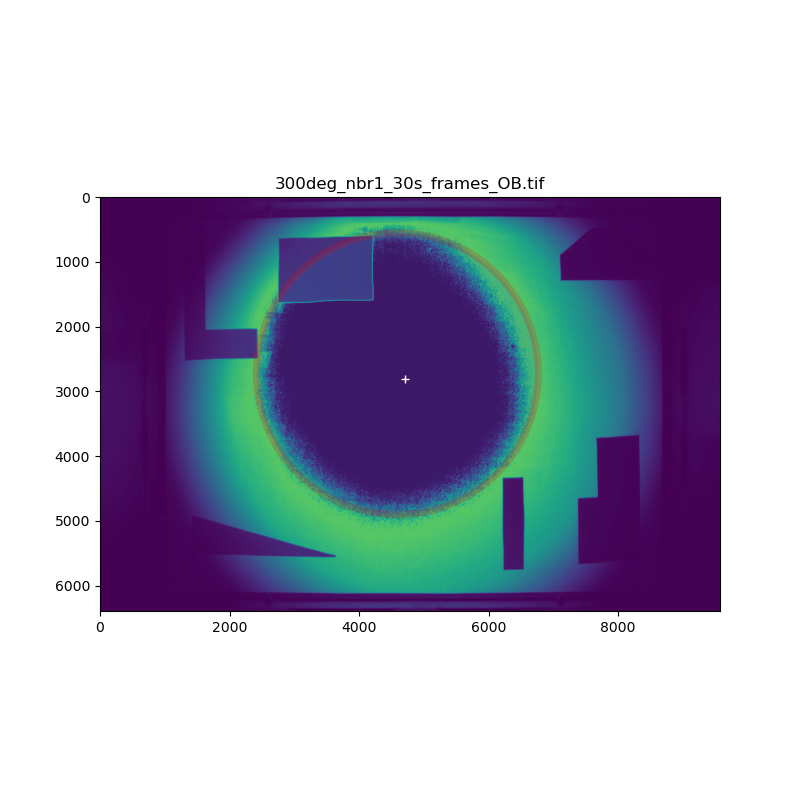

interactive(children=(Dropdown(description='file_name', layout=Layout(width='500px'), options=('0deg_30s_frame…

In [20]:
fig, axis = plt.subplots(num="80% coverage", figsize=(8, 8), nrows=1, ncols=1)

file_name, vmin, vmax = display_images.result

def plot(file_name, vmin, vmax):

    axis.cla()
    data = images[file_name]
    axis.imshow(data, vmin=vmin, vmax=vmax)
    axis.set_title(file_name)
    
    key = filename_starts_with(file_name)
    x_center = mean_centers[key]['x']
    y_center = mean_centers[key]['y']
    axis.plot(x, y, 'w+')
    
    beam_center_intensity = mean_centers[key]['average_intensity']
    mask = np.where(data > (beam_center_intensity * 80)/100)
    
    import copy
    mask_image = copy.deepcopy(data)
    mask_image[mask] = 0
    mask_image[y, x] = beam_center_intensity
    axis.imshow(mask_image)
    
    exp_circle = plt.Circle((x_center, y_center), beam_radius_px, 
                            facecolor=None,
                            lw=5,
                           alpha=0.2,
                           edgecolor='red',
                            label='theoretical beam')
    axis.add_patch(exp_circle)

    
display_80_percent = interactive(plot,
                            file_name = widgets.Dropdown(options=images.keys(),
                                                         value=file_name,
                                                        layout=widgets.Layout(width="500px")),
                            vmin = widgets.FloatSlider(min=vmin_value,
                                          max=vmax_value,
                                          value=vmin_value,
                                          continuous_update=False),
                            vmax = widgets.FloatSlider(min=vmin_value,
                                                       max=vmax_value,
                                                       value=vmax_value,
                                                       continuous_update=False),
                           )
display(display_80_percent)

# different approach to plot 

<IPython.core.display.Javascript object>


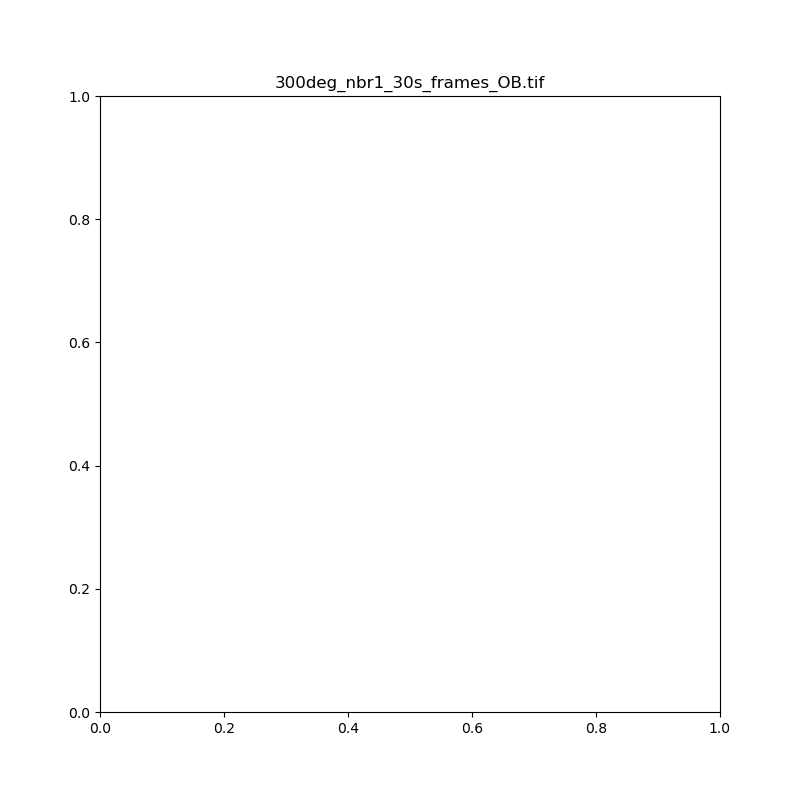

interactive(children=(Dropdown(description='file_name', index=14, layout=Layout(width='500px'), options=('0deg…

In [66]:
# fig1, axis1 = plt.subplots(num="80% coverage - bis", figsize=(8, 8), nrows=1, ncols=1)

# file_name, vmin, vmax = display_images.result

# def plot(file_name, vmin, vmax):

#     data = images[file_name]
#     data = median(data, disk(5))
#     axis.imshow(data, vmin=vmin, vmax=vmax)
#     axis1.set_title(file_name)
        
# #     key = filename_starts_with(file_name)

# #     beam_center_intensity = mean_centers[key]['average_intensity']
# #     y_mask, x_mask = np.where(data > (beam_center_intensity * 80)/100)
# #     axis1.plot(x_mask, y_mask, '.r')
    
# #     # exp center
# #     x_center = mean_centers[key]['x']
# #     y_center = mean_centers[key]['y']
# #     axis1.plot(x, y, 'w+')
# #     plt.text(x, y+400, f"  Perfect center: ({x_center}, {y_center})", color="white")
    
# #     # theoretical center
# #     axis1.plot(perfect_center_x_px, perfect_center_y_px, 'b+')
# #     plt.text(perfect_center_x_px, perfect_center_y_px+400, f"  Theor. center: ({perfect_center_x_px}," + 
# #              f"{perfect_center_y_px})", color="blue")
    
    
# display_80_percent = interactive(plot,
#                             file_name = widgets.Dropdown(options=images.keys(),
#                                                          value=file_name,
#                                                         layout=widgets.Layout(width="500px")),
#                             vmin = widgets.FloatSlider(min=vmin_value,
#                                           max=vmax_value,
#                                           value=vmin_value,
#                                           continuous_update=False),
#                             vmax = widgets.FloatSlider(min=vmin_value,
#                                                        max=vmax_value,
#                                                        value=vmax_value,
#                                                        continuous_update=False),
#                            )
# display(display_80_percent)